## 09 회귀 실습 - 자전거대여 수요 예측

### 데이터 클렌징 및 가공

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/Users/adam/Data_Analytics/Python/Datasets/bike-sharing-demand/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [85]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [64]:
# datetime 컬럼만 object 형이다.
# datetime 컬럼의 경우 년-월-일 시:분:초 문자 형식으로 돼 있으므로 이에 대한 가공이 필요하다.
# datetime을 년,월,일,시간 과 같이 4개의 속성으로 분리하자.
# 문자열을 'datetime'타입으로 변경해야 한다.
# 판다스는 문자열을 datetime 타입으로 변환하는 apply(pd.to_datetime) 메서드를 제공한다.

In [86]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [6]:
# 새롭게 year, month, day, hour 컬럼이 추가 됐다. 이제 datetime 컬럼은 삭제하자.
# casual 컬럼 + registered 컬럼 = count 컬럼 이므로 두 컬럼이 따로 필요하지 않다.
# 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 이 두 컬럼도 삭제하자.

In [87]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

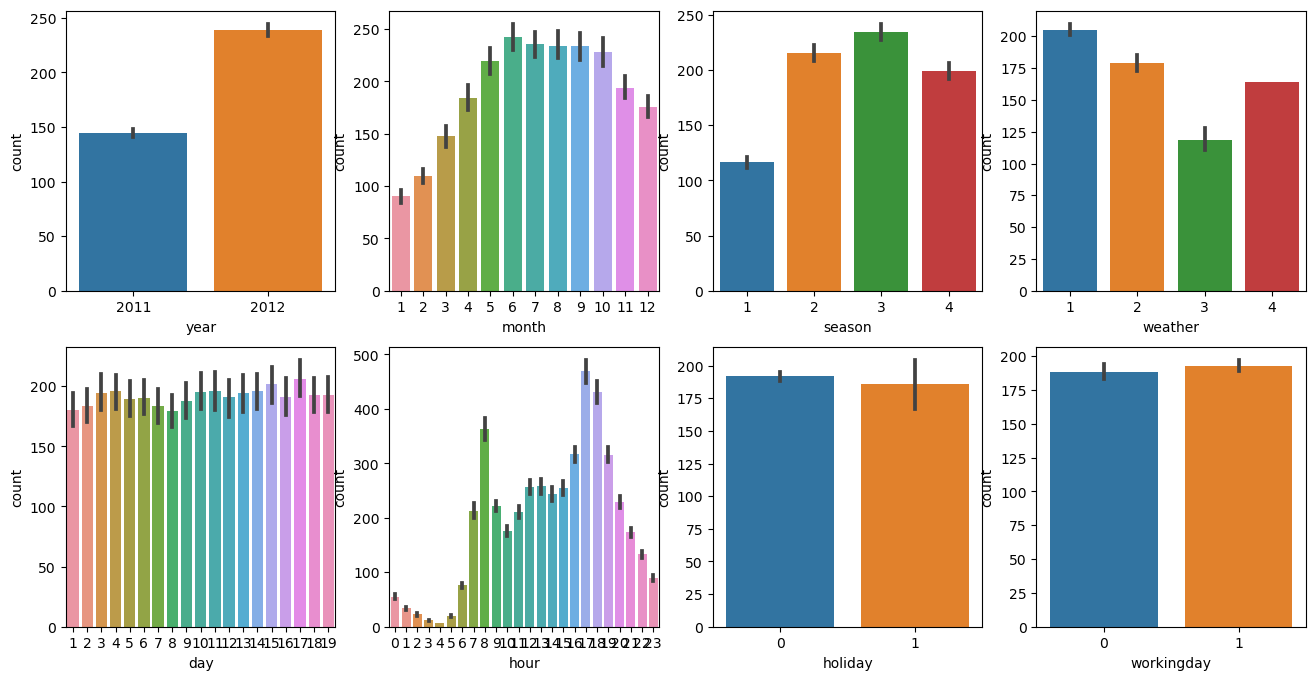

In [88]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [8]:
# 다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정해보자.
# 캐글에서는 RMSLE(Root Mean Squared Log Error)를 성능 평가 방법이지만,
# 사이킷런은 RMSLE를 제공하지 않아서 RMSLE를 수행하는 성능 평가 함수를 직접 만든다.

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [10]:
# 위의 rmse() 함수를 만들 때 한 가지 주의해야 할 점이 있다.
# rmse()를 구할 때 넘파이의 log() 함수를 이용하거나 사이킷런의 mean_squared_log_error()를 이용할 수도 있지만,
# 데이터 값의 크기에 따라 오버플로/언더플로(overflow/underflow) 오류가 발생하기 쉽다.

In [ ]:
# 다음과 같은 rmsle 구현은 오버플로우나 언더플로우 오류가 발생되기 쉽다.
# def rmsle(y, pred):
#    msle = mean_squared_log_error(y, pred)
#    rmsle = np.sqrt(mse)
#    return rmsle

In [11]:
# 따라서 log() 보다는 log1p()를 이용하는데, log1p()의 경우
# 1+log() 값으로 log 변환값에 1을 더하므로 이런 문제를 해결해 준다.
# log1()로 변환된 값은 다시 넘파이의 expm1() 함수로 쉽게 원래 스케일로 복원될 수 있다.

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 

In [12]:
# 회귀 모델을 적용하기 전에 데이터 세트에 대해서 먼저 처리해야 할 사항이 있다.
# 결과 값이 정규 분포로 되어 있는지 확인 하는 것,
# 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩 하는 것 이다.

In [90]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [17]:
# 예측 오류로서는 비교적 큰 값이다. 실제 값과 예측 값이 어느 정도 차이가 나는지
# DataFrame의 컬럼을 만들어서 확인해보자.

In [91]:
def get_top_error_data(y_test, pred, n_tops = 5):
    
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


In [71]:
# 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은
# Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이다.
# Target 값의 분포는 정규 분포 형태가 가장 좋다.

<Axes: >

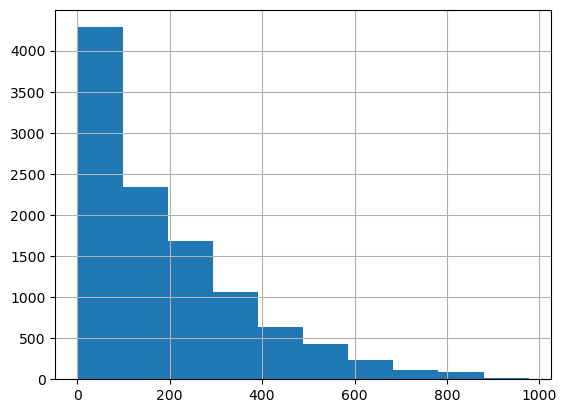

In [92]:
y_target.hist()

In [21]:
# count 컬럼 값이 정규 분포가 아닌 0~200 사이에 왜곡돼 있는 것을 알 수 있다.
# 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환 하는 것이다.

<Axes: >

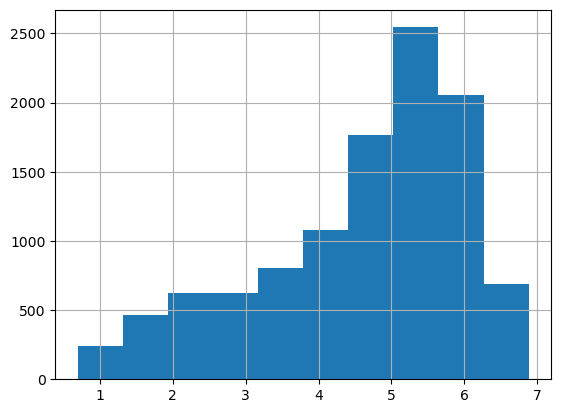

In [93]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [23]:
# 로그로 변환한 후에 원하는 정규 분포 형태는 아니지만 변환하기 전보다 왜곡 정도가 많이 향상 됐다.

In [94]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


In [75]:
# RMSLE 오류는 줄었지만, RMSE는 오히려 더 늘어났다.
# 각 피처의 회귀 계수 값을 시각화 해보자.

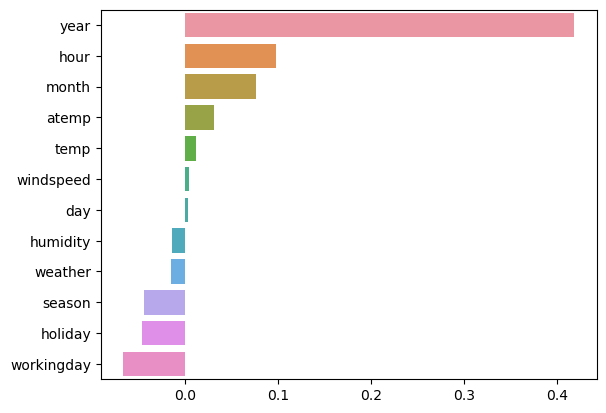

In [95]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

In [35]:
# year 피처는 연도를 뜻하므로 카테고리(Category)형 피처지만, 숫자형 값으로 되어있다.
# 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다.
# 하지만, 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때
# 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다.
# 따라서, 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

In [96]:
# 판다스의 get_dummies()를 이용해 카테고리형 컬럼을 모두 변환한 후 다시 예측 성능을 확인 해보자.

# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [97]:
# 사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능 확인한다.

# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.689, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


In [79]:
# 원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상 됐다.
# 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화 해보자.

<Axes: >

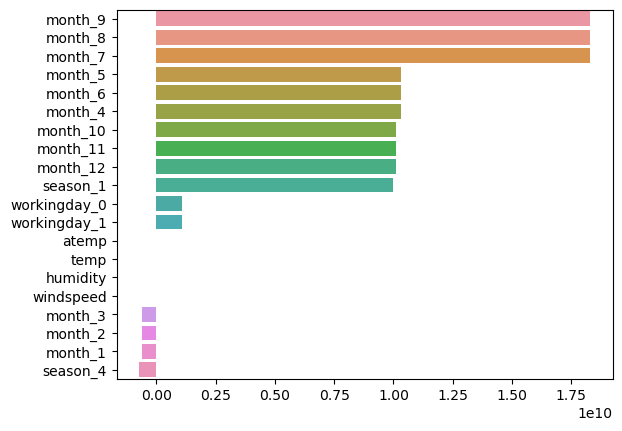

In [98]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [60]:
# 선형 회귀 수행 시에는 피처를 어떻게 인코딩하는가가 성능에 큰 영향을 미칠 수 있다.

In [99]:
# 이번에는 회귀 트리를 이용해 회귀 예측을 수행해보자

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)


### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.239, MAE: 31.154
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.330, MAE: 32.741
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
